In [1]:
import tqdm
import types
import itertools
import pandas as pd
import matplotlib.pyplot as plt
#PyTorch
import torch

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import likelihoods
import losses
import metrics
import priors
import utils

In [3]:
cifar10_dir = "/cluster/tufts/hugheslab/eharve06/CIFAR-10"
cifar101_v4_dir = "/cluster/tufts/hugheslab/eharve06/CIFAR-10.1"
ns = [100, 1_000, 10_000, 50_000]
random_states = [1001, 2001, 3001]
repo_dir = "/cluster/tufts/hugheslab/eharve06/random-Fourier-features"

for n, random_state in itertools.product(ns, random_states):
    encoded_path = f"{repo_dir}/datasets/CIFAR-10/n={n}_random_state={random_state}.pth"
    print(
        f"    \'python ../src/encode_cifar10.py "
        f"--batch_size=128 "
        f"--cifar10_dir=\"{cifar10_dir}\" "
        f"--cifar101_v4_dir=\"{cifar101_v4_dir}\" "
        f"--encoded_path=\"{encoded_path}\" "
        f"--n={n} "
        f"--num_workers=0 "
        f"--random_state={random_state}\'"
    )


    'python ../src/encode_cifar10.py --batch_size=128 --cifar10_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10" --cifar101_v4_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10.1" --encoded_path="/cluster/tufts/hugheslab/eharve06/random-Fourier-features/datasets/CIFAR-10/n=100_random_state=1001.pth" --n=100 --num_workers=0 --random_state=1001'
    'python ../src/encode_cifar10.py --batch_size=128 --cifar10_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10" --cifar101_v4_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10.1" --encoded_path="/cluster/tufts/hugheslab/eharve06/random-Fourier-features/datasets/CIFAR-10/n=100_random_state=2001.pth" --n=100 --num_workers=0 --random_state=2001'
    'python ../src/encode_cifar10.py --batch_size=128 --cifar10_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10" --cifar101_v4_dir="/cluster/tufts/hugheslab/eharve06/CIFAR-10.1" --encoded_path="/cluster/tufts/hugheslab/eharve06/random-Fourier-features/datasets/CIFAR-10/n=100_random_state=3001.pth" --n=100 --num

In [4]:
logits = torch.tensor([[3.0, -1.0], [-1.0, 2.0], [0.0, 1.0], [-1.0, 3.0]])
probs = torch.nn.functional.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)
labels = torch.tensor([0, 0, 1, 1]).long()
metrics.balanced_accuracy(preds, labels)

tensor(0.7500)

In [5]:
metrics.abstention_metric(logits, labels)

0.625

In [6]:
n, random_state = 100, 1001
datasets = torch.load(f"{repo_dir}/datasets/CIFAR-10/n={n}_random_state={random_state}.pth", map_location=torch.device("cpu"), weights_only=False)

full_dataset = torch.utils.data.TensorDataset(
    torch.cat([datasets["X_train"], datasets["X_val"]], dim=0),
    torch.cat([datasets["y_train"], datasets["y_val"]], dim=0),
)
train_dataset = torch.utils.data.TensorDataset(datasets["X_train"], datasets["y_train"])
val_dataset = torch.utils.data.TensorDataset(datasets["X_val"], datasets["y_val"])
test_dataset = torch.utils.data.TensorDataset(datasets["X_test"], datasets["y_test"])
ood_dataset = torch.utils.data.TensorDataset(datasets["X_ood"], datasets["y_ood"])

batch_size = 128
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
ood_dataloader = torch.utils.data.DataLoader(ood_dataset, batch_size=batch_size)


In [7]:
def train_one_epoch(model, criterion, optimizer, dataloader, num_samples=1):
    
    model.train()

    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    
    total_loss = 0.0
    for X_batch, y_batch in dataloader:
        
        batch_size = len(X_batch)
        
        optimizer.zero_grad()
        params = utils.flatten_params(model)
        
        for _ in range(num_samples):
            logits = model(X_batch)
            loss = criterion(logits, y_batch, params, len(dataloader.dataset))
            total_loss += (batch_size / dataset_size) * (1 / num_samples) * loss.item()
            loss.backward()
            
        for group in optimizer.param_groups:
            for param in group["params"]:
                if param.grad is not None:
                    param.grad.data.mul_(1/num_samples)

        for group in optimizer.param_groups:
            torch.nn.utils.clip_grad_norm_(group["params"], max_norm=1.0)
            
        optimizer.step()
        
    return total_loss
        
def evaluate(model, criterion, dataloader):
    
    model.eval()
    
    dataset_size = len(dataloader) * dataloader.batch_size if dataloader.drop_last else len(dataloader.dataset)
    
    with torch.no_grad():
        
        total_loss = 0.0
        for X_batch, y_batch in dataloader:

            batch_size = len(X_batch)
            
            params = utils.flatten_params(model)
            logits = model(X_batch)
            loss = criterion(logits, y_batch, params, len(dataloader.dataset))
            total_loss += (batch_size / dataset_size) * loss.item()
            
    return total_loss


In [8]:
model = layers.RFFLaplace(in_features=2048, out_features=10, rank=1024, lengthscale=20.0, outputscale=1.0)
likelihood = likelihoods.CategoricalLikelihood()
prior = priors.GaussianPrior(learnable_tau=False, tau=1.0)

map_objective = losses.MAPLoss(likelihood, prior)
cross_entropy = losses.ERMLoss(likelihood)

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

columns = ["lr", "epoch", "train_loss", "val_loss"]
model_history_df = pd.DataFrame(columns=columns)
best_state_dict = None

for lr in [0.1, 0.01, 0.001, 0.0001]:

    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer = torch.optim.Adam([{"params": model.parameters()}, {"params": likelihood.parameters()}, {"params": prior.parameters()}], lr=lr, weight_decay=0.0)
    
    epochs = 10_000
    
    for epoch in tqdm.tqdm(range(epochs)):
        
        train_loss = train_one_epoch(model, map_objective, optimizer, train_dataloader)
        val_loss = evaluate(model, cross_entropy, val_dataloader)
        
        model_history_df.loc[len(model_history_df)] = [lr, epoch, train_loss, val_loss]
        
        if val_loss == model_history_df["val_loss"].min(): 
            best_state_dict = {
                "model": model.state_dict(),
                "likelihood": likelihood.state_dict(),
                "prior": prior.state_dict(),
            }
        
model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])


100%|██████████| 10000/10000 [01:15<00:00, 132.77it/s]


<All keys matched successfully>

0.1


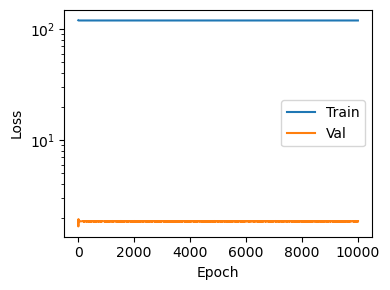

In [9]:
best_lr = model_history_df.lr[model_history_df.val_loss.idxmin()]
temp_df = model_history_df[model_history_df.lr == best_lr]

print(best_lr)

ncols, nrows = 1, 1

fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(temp_df.epoch, temp_df.train_loss, label="Train")
ax.plot(temp_df.epoch, temp_df.val_loss, label="Val")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

fig.tight_layout()
plt.show()

In [10]:
with torch.no_grad():
    
    model.eval()
    
    model.update_covariance_from_dataloader(train_dataloader)

    test_probs = model.predict_proba(datasets["X_test"], num_samples=10_000)
    ood_probs = model.predict_proba(datasets["X_ood"], num_samples=10_000)
        
    test_preds = torch.argmax(test_probs, dim=1)
    ood_preds = torch.argmax(ood_probs, dim=1)

    test_acc = metrics.balanced_accuracy(test_preds, datasets["y_test"])
    ood_acc = metrics.balanced_accuracy(ood_preds, datasets["y_ood"])
    
    print(test_acc.item())
    print(ood_acc.item())


0.6955999135971069
0.5629934072494507
